<img src="ublogo.png"/>

# CSE474/574 - Introduction to Machine Learning

  - Python Demonstrations
  - Instructor - Varun Chandola


In [32]:
import numpy as np
import pandas as pd
import time
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from perceptronutils import *
import plotly.graph_objects as go
import plotly.express as px

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=2)
%matplotlib inline

## Plotting linear functions
$$
{\bf w}^\top{\bf x} + w_0
$$

Text(0, 0.5, 'x2')

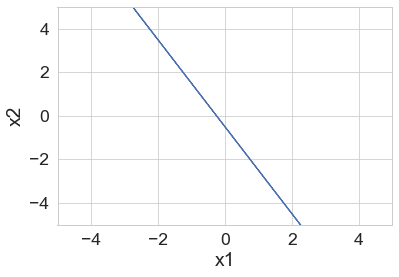

In [3]:
w = [4,2]
w0 = 1
x1min,x1max = [-10,10]
x2min,x2max = [-10,10]
x11,x12 = x1min,(-w0-w[0]*x1min)/w[1]
x21,x22 = x1max,(-w0-w[0]*x1max)/w[1]
x31,x32 = (-w0-w[1]*x2min)/w[0],x2min
x41,x42 = (-w0-w[1]*x2max)/w[0],x2max

plt.plot([x11,x21,x31,x41],[x12,x22,x32,x42])
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel('x1')
plt.ylabel('x2')

## Why not use the 0-1 loss function

Below is the implementation of the `0-1` loss function.

$$
J({\bf w}) = \sum_{i=1}^N \mathbb{1}[y_i({\bf w}^\top{\bf x}_i) < 0]
$$

```python
def zerooneobjfunc(w,X,y):
    return np.sum(y*np.dot(X,w) < 0)
```

We will consider a 2-D data set. The decision boundary (or the line) will be represented using three parameters ($w_0, w_1, w_2$). We will evaluate the objective function for different combinations of the three parameters and then plot the objective function as a function of only the last two parameters (*Since we cannot plot a 4D plot*) 

In [4]:
def zerooneobjfunc(w,X,y):
    return np.sum(y*np.dot(X,w) < 0)

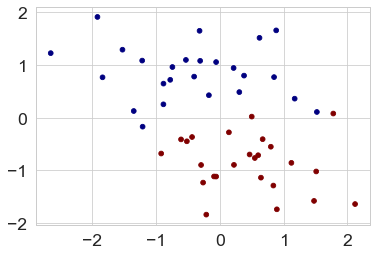

In [5]:
# consider a simple 2-D data set
# prepare data
# make_blobs is a function provided by sklearn to generate synthetic data
X, y = make_blobs(n_samples=50, centers=2, n_features=2, random_state=0)
X = StandardScaler().fit_transform(X)
X_i = np.hstack([np.ones((X.shape[0],1)),X])
y[y == 0] = -1
y = y[:,np.newaxis]
plt.scatter(X[:,0],X[:,1],c=y.flatten(),cmap='jet')

In [6]:
w1s = w2s = np.linspace(-200,200,200)
W1,W2 = np.meshgrid(w1s,w2s)

In [7]:
losses = []
w0 = 10
for w1,w2 in zip(W1.flatten(),W2.flatten()):
    w = np.array([[w0],[w1],[w2]])
    #losses.append(computeLoss(X,y,w))
    losses.append(zerooneobjfunc(w,X_i,y))

In [8]:
losses = np.array(losses)
J = np.reshape(losses,W1.shape)

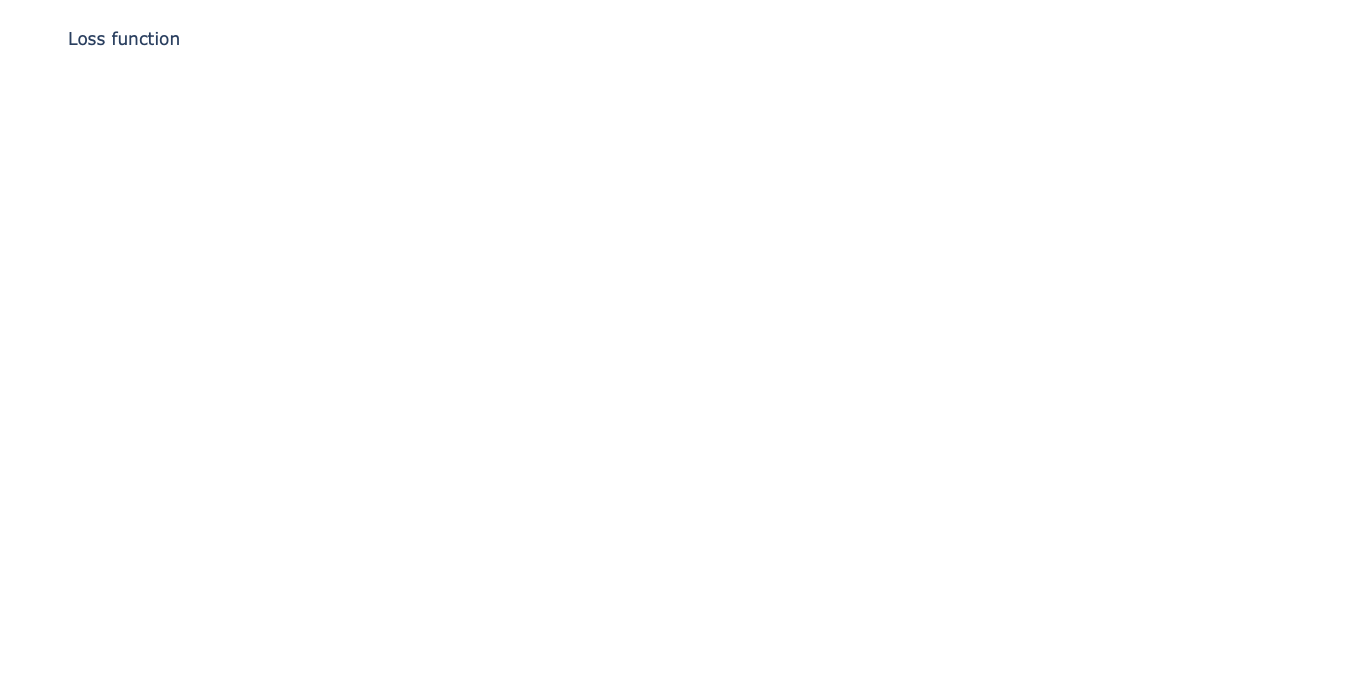

In [9]:
cs = 'oranges'
fig = go.Figure(data=[go.Surface(z=J, x=W1, y=W2,
                                 contours = {"x": {"show": True},
                                             "y": {"show": True}
                                            },
                                 showscale=False,
                                 colorscale=cs
                                )])
fig.update_layout(title='Loss function', autosize=False,
                  width=500, height=700,
                  margin=dict(l=65, r=50, b=65, t=90))

In [ ]:
# an alternative no-plotly way of generating the 3d surface
fig = plt.figure(figsize=(14,8))

ax = fig.add_subplot(projection='3d')
ax.plot_surface(W1, W2, J, rstride=1, cstride=1,
                cmap='autumn_r', edgecolor='none')


# Loss Functions

Here we study the different types of loss functions and how they are different from each other. In particular, the `0-1` loss function is the one that we aspire to be. However, as shown later, the objective function that uses the `0-1` loss function is *hard* to optimize over. 

In the example below, we are assuming that we have only one training example, whose label is `+1`. 


In [22]:
def zerooneloss(f,y):
    if f*y > 0:
        return 0
    else:
        return 1
    
def squaredloss(f,y):
    return 0.5*np.power(f-y,2)

def logisticloss(f,y):
    return np.log(1+np.exp(-f*y))
    #return np.exp(-f*y)

def hingedloss(f,y):
    return max(0,1-f*y)

In [39]:
wtx = np.linspace(-1,3,500)
lossfuncs = {'0-1':zerooneloss,'squared':squaredloss,'logistic':logisticloss,'hinged':hingedloss}
losses = {}
for l,func in lossfuncs.items():
    loss = []
    for f in wtx:
        loss.append(func(f,1))
    losses[l] = loss
df_loss = pd.DataFrame.from_dict(losses,orient='columns')
df_loss['x'] = wtx

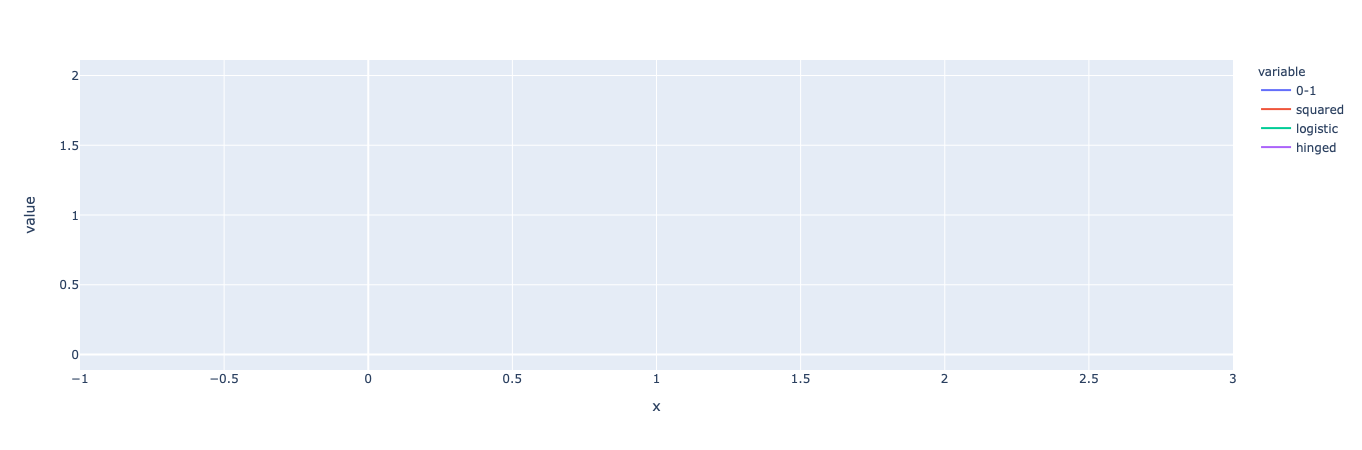

In [40]:
fig = px.line(df_loss, x='x', y=list(lossfuncs.keys()))
fig.show()

The conclusion from above is that while `0-1` loss is the loss that we want to optimize over, its shape is not conducive for optimization methods. The other loss-functions approximate this step function with other functions that are easier to optimize over.

## Perceptron Demo


In [41]:
def plotBoundary(X,y,w,ax):
    h = .02  # step size in the mesh

    X1_min, X1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    X2_min, X2_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    X1_, X2_ = np.meshgrid(np.arange(X1_min, X1_max, h),np.arange(X2_min, X2_max, h))
    Xpred = np.c_[np.ones(len(X1_.ravel())),X1_.ravel(), X2_.ravel()]
    ypred = np.dot(Xpred,w)
    ypred_ = np.zeros(ypred.shape)
    ypred_[ypred >= 0] = 1
    ypred_[ypred < 0] = -1
    ypred = ypred_.reshape(X1_.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.pcolormesh(X1_, X2_, ypred, cmap=cm_bright,alpha=.1)
    sp = ax.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=cm_bright)
    
    ax.set_xlim(X1_.min(), X1_.max())
    ax.set_ylim(X2_.min(), X2_.max())
    ax.set_xticks(())
    ax.set_yticks(())

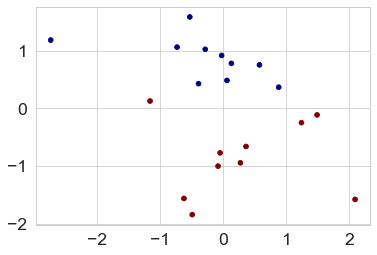

In [49]:
# prepare data
# make_blobs is a function provided by sklearn to generate synthetic data
X, y = make_blobs(n_samples=20, centers=2, n_features=2, random_state=0)
X = StandardScaler().fit_transform(X)
y[y == 0] = -1
y = y[:,np.newaxis]
plt.scatter(X[:,0],X[:,1],c=y.flatten(),cmap='jet')

In [56]:
eta = 0.02
# initialize w
winit = np.array([1,1,1])
winit = winit[:,np.newaxis]
w = winit
losses = []
mistakes = []
numiters = 20

After iteration 0
[44.191805849197046]
[13]
[[20.        ]
 [ 7.01238981]
 [30.29938462]]
[[1]
 [1]
 [1]]
After iteration 1
[44.191805849197046, 21.731461613080167]
[13, 12]
[[12.        ]
 [ 8.37664825]
 [19.14454002]]
[[0.6       ]
 [0.8597522 ]
 [0.39401231]]
After iteration 2
[44.191805849197046, 21.731461613080167, 11.999223026605373]
[13, 12, 11]
[[ 7.2       ]
 [ 7.66028968]
 [12.63935607]]
[[0.36      ]
 [0.69221924]
 [0.01112151]]


/Users/chandola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



After iteration 3
[44.191805849197046, 21.731461613080167, 11.999223026605373, 7.4083963034860645]
[13, 12, 11, 5]
[[4.32      ]
 [6.33535715]
 [8.63767432]]
[[ 0.216     ]
 [ 0.53901345]
 [-0.24166561]]
After iteration 4
[44.191805849197046, 21.731461613080167, 11.999223026605373, 7.4083963034860645, 5.123261518332593]
[13, 12, 11, 5, 3]
[[2.592     ]
 [4.9897637 ]
 [6.05435371]]
[[ 0.1296   ]
 [ 0.4123063]
 [-0.4144191]]
After iteration 5
[44.191805849197046, 21.731461613080167, 11.999223026605373, 7.4083963034860645, 5.123261518332593, 3.9477813093369365]
[13, 12, 11, 5, 3, 2]
[[1.5552    ]
 [3.8269411 ]
 [4.31920685]]
[[ 0.07776   ]
 [ 0.31251103]
 [-0.53550617]]
After iteration 6
[44.191805849197046, 21.731461613080167, 11.999223026605373, 7.4083963034860645, 5.123261518332593, 3.9477813093369365, 3.330777561898212]
[13, 12, 11, 5, 3, 2, 2]
[[0.93312   ]
 [2.89049023]
 [3.11811361]]
[[ 0.046656  ]
 [ 0.23597221]
 [-0.62189031]]
After iteration 7
[44.191805849197046, 21.73146161308

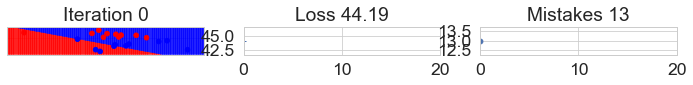

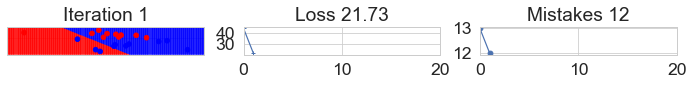

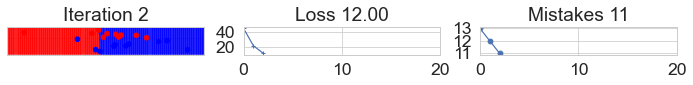

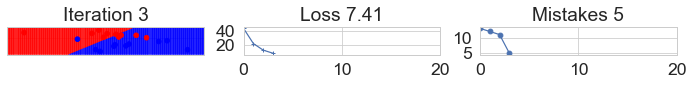

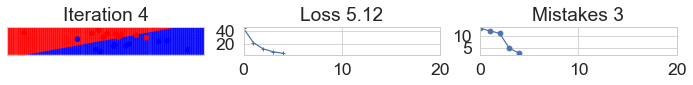

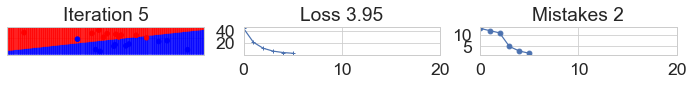

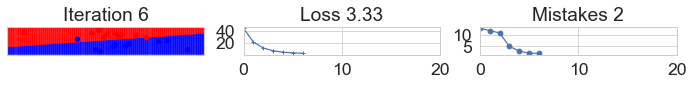

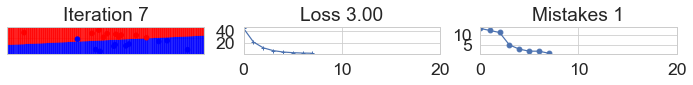

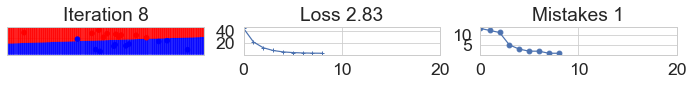

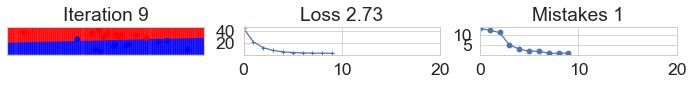

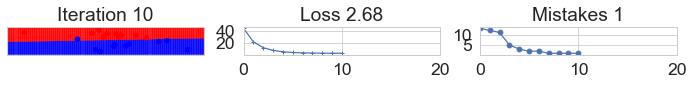

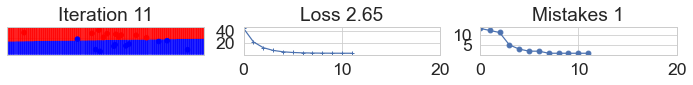

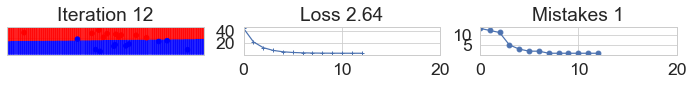

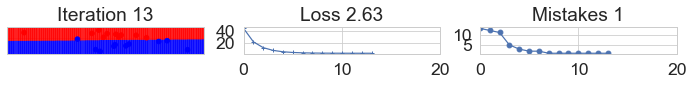

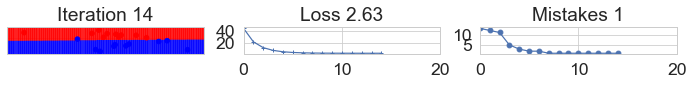

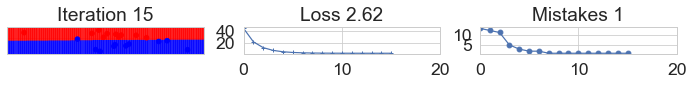

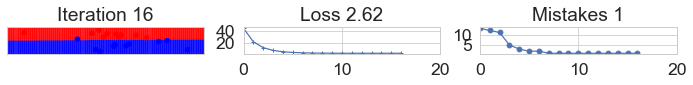

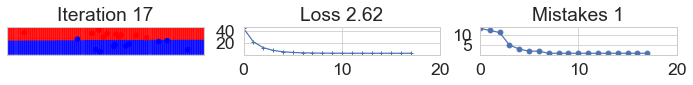

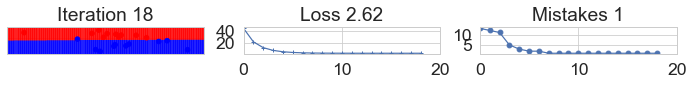

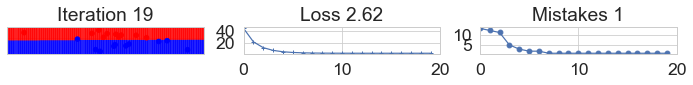

In [57]:
for iter in range(numiters):
    print("After iteration %d"%iter)
    # compute loss
    losses.append(computeLoss(X,y,w))
    # compute number of mistakes
    mistakes.append(computeMistakes(X,y,w))
    # compute gradient
    grad = computeGradient(X,y,w)
    print(losses)
    print(mistakes)
    print(grad)
    print(w)
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(numiters,3,3*iter+1)
    # plot current boundary
    plotBoundary(X,y,w,ax)
    ax.set_title('Iteration %d'%iter)
    # plot losses
    ax = fig.add_subplot(numiters,3,3*iter+2)
    ax.plot(range(len(losses)),losses,'-+')
    ax.set_xlim([0,numiters])
    ax.set_title('Loss %.2f'%losses[iter])
    # plot mistakes
    ax = fig.add_subplot(numiters,3,3*iter+3)
    ax.plot(range(len(mistakes)),mistakes,'-o')
    ax.set_xlim([0,numiters])
    ax.set_title('Mistakes %d'%mistakes[iter])
    # update weight
    w = w - eta*grad
